In [ ]:
from google.colab import files

uploaded = files.upload()


Saving Group_4.zip to Group_4 (1).zip


In [ ]:

import zipfile
import io

zip_file_path = list(uploaded.keys())[0]

with zipfile.ZipFile(io.BytesIO(uploaded[zip_file_path]), 'r') as zip_ref:
    zip_ref.extractall('/content/')


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
def residual_block(X, filters, kernel_size=3, strides=1):
    shortcut = X

    X = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(X)
    X = BatchNormalization()(X)

    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='valid')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    X = Add()([X, shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet34(input_shape=(224, 224, 3), num_classes=5):
    X_input = Input(input_shape)

    X = Conv2D(64, (7, 7), strides=2, padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = residual_block(X, filters=64, strides=1)
    X = residual_block(X, filters=64, strides=1)
    X = residual_block(X, filters=64, strides=1)

    X = residual_block(X, filters=128, strides=2)
    X = residual_block(X, filters=128, strides=1)
    X = residual_block(X, filters=128, strides=1)
    X = residual_block(X, filters=128, strides=1)

    X = residual_block(X, filters=256, strides=2)
    X = residual_block(X, filters=256, strides=1)
    X = residual_block(X, filters=256, strides=1)
    X = residual_block(X, filters=256, strides=1)
    X = residual_block(X, filters=256, strides=1)
    X = residual_block(X, filters=256, strides=1)

    X = residual_block(X, filters=512, strides=2)
    X = residual_block(X, filters=512, strides=1)
    X = residual_block(X, filters=512, strides=1)

    X = GlobalAveragePooling2D()(X)

    X = Dense(num_classes, activation='softmax')(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet34')

    return model

In [ ]:
resnet34_model = ResNet34()
resnet34_model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 112, 112, 64)         0         ['batch_normalization[0

In [ ]:
def train_resnet(model, train_data_dir, test_data_dir, epochs=50, batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical'
    )

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint('best_model_resnet34.h5', save_best_only=True, monitor='val_accuracy', mode='max')

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size,
        callbacks=[checkpoint]
    )

    return history

train_data_dir = '/content/Group_4/train'
test_data_dir = '/content/Group_4/test'

resnet34_model = ResNet34()
history = train_resnet(resnet34_model, train_data_dir, test_data_dir, epochs=50, batch_size=32)

best_model = load_model('best_model_resnet34.h5')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

print("Train Accuracy:", history.history['accuracy'][-1])

test_evaluation = best_model.evaluate(test_generator)
print("Test Accuracy:", test_evaluation[1])


Found 2150 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 1.7378 - accuracy: 0.3631

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 76s 666ms/step - loss: 1.7378 - accuracy: 0.3631 - val_loss: 133.8974 - val_accuracy: 0.2009
Epoch 2/50
67/67 [==============================] - 42s 625ms/step - loss: 1.2235 - accuracy: 0.5033 - val_loss: 2.4167 - val_accuracy: 0.3482
Epoch 3/50
67/67 [==============================] - 41s 610ms/step - loss: 1.1282 - accuracy: 0.5486 - val_loss: 1.9189 - val_accuracy: 0.2634
Epoch 4/50
67/67 [==============================] - 44s 659ms/step - loss: 1.0581 - accuracy: 0.5637 - val_loss: 1.6850 - val_accuracy: 0.3527
Epoch 5/50
67/67 [==============================] - 41s 611ms/step - loss: 0.9426 - accuracy: 0.6100 - val_loss: 4.5005 - val_accuracy: 0.2589
Epoch 6/50
67/67 [==============================] - 42s 619ms/step - loss: 0.9759 - accuracy: 0.6020 - val_loss: 1.4716 - val_accuracy: 0.4643
Epoch 7/50
67/67 [==============================] - 41s 604ms/step - loss: 0.8874 - accuracy: 0.6501 - val_loss: 5.6254 - val_accuracy: 0.2143
Epoch 8/

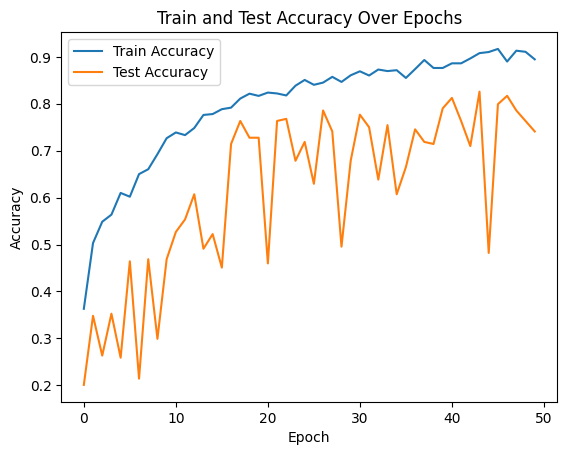

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Train and Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Found 250 images belonging to 5 classes.
8/8 [==============================] - 2s 178ms/step


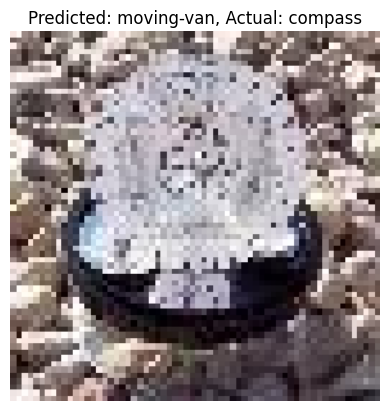

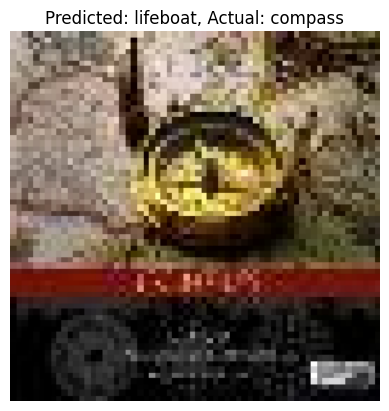

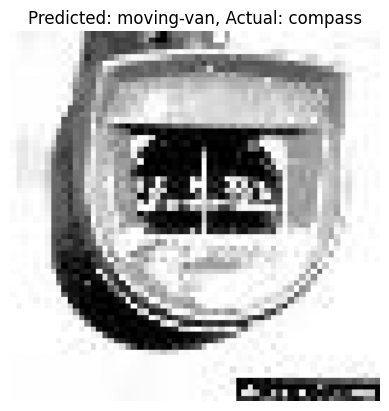

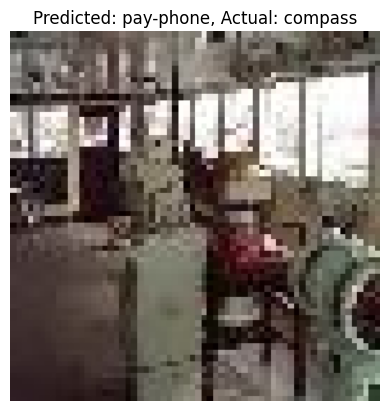

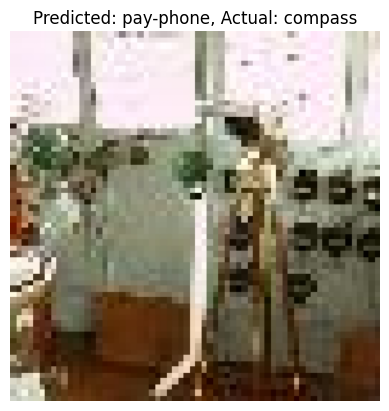

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

predictions = best_model.predict(test_generator)

true_labels = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

misclassified_indices = np.where(np.argmax(predictions, axis=1) != true_labels)[0]


for idx in misclassified_indices[:5]:
    img_path = test_generator.filepaths[idx]
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0


    plt.imshow(img_array[0])
    plt.title(f'Predicted: {class_labels[np.argmax(predictions[idx])]}, Actual: {class_labels[true_labels[idx]]}')
    plt.axis('off')
    plt.show()